In [ ]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 현재 경로 확인
!pwd

/content


In [ ]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

/content/drive/My Drive/Colab Notebooks


## Image(Object) Classification

```python 
이미지 분류 흐름 
 
비용 절감 vs 성능 향상
┌─ 사람이 만든 알고리즘 (Rule 기반)   
└─ ML   ┌─ 전통적인 ML
        └─ Deep Learning 
             └─ 크기와 위치가 같은 상황에서만 성능이 좋음 (가정이 필요)
                     ┌─ FN  
                     └─ CNN          
                         └─ Capacity가 크면 클 수록 성능이 좋다 
                            (kernel, filter, layer, perceptron 개수 등) 
                                └─ 이미지 데이터 개수가 아주 많아야 한다 
                                      └─ Augmentation (데이터 뻥튀기) 
                                          └─ 데이터 양의 한계가 있을 때
                                             └─ Transfer learing  
                                                 ┌─ Feature Extraction
                                                 └─ Fine Tuning 
```

## Image data 저장 방법

```python
- Directory -> 대부분 이 방법을 사용
- HDF -> 연구용 
- LMDB 
```

## 데이터를 불러오는 방법

### ImageDataGenerator + tf.data

```
ImageDataGenerator를 활용하여 저장, 전처리, augmentation을 사용할 수 있지만 속도가 느리기 때문에 
ImageDataGenerator와 tf.data를 섞어 사용하면 훨씬 효율적이다 
```

In [ ]:
import tensorflow as tf 

In [ ]:
idg = tf.keras.preprocessing.image.ImageDataGenerator() # 옵션을 사용해서 저장, augmentation을 사용할 수 있는 장점이 있다 
didg = idg.flow_from_directory('flower_photos/')

Found 3670 images belonging to 5 classes.


In [ ]:
next(didg)[0].dtype, next(didg)[0].shape

(dtype('float32'), (32, 256, 256, 3))

In [ ]:
next(didg)[1].dtype, next(didg)[1].shape

(dtype('float32'), (32, 5))

In [ ]:
train = tf.data.Dataset.from_generator(lambda: didg, output_types=(tf.float32, tf.float32), output_shapes=((None,256,256,3),(None,5))) # 인자에는 callable이 들어가야 한다 

In [ ]:
train

<FlatMapDataset shapes: ((None, 256, 256, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [ ]:
for i in train.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[124., 118.,  94.],
         [125., 123., 102.],
         [112., 106.,  92.],
         ...,
         [ 10.,  17.,   9.],
         [  8.,  18.,   9.],
         [  7.,  19.,   9.]],

        [[111., 106.,  84.],
         [122., 121., 100.],
         [115., 112.,  95.],
         ...,
         [ 10.,  17.,   9.],
         [  8.,  18.,   9.],
         [  8.,  18.,   9.]],

        [[108., 103.,  84.],
         [124., 123., 103.],
         [118., 116.,  95.],
         ...,
         [ 10.,  17.,   9.],
         [ 10.,  17.,   9.],
         [ 11.,  16.,   9.]],

        ...,

        [[163., 127., 129.],
         [157., 118., 119.],
         [ 26.,  37.,  20.],
         ...,
         [  6.,  11.,   5.],
         [  6.,  11.,   5.],
         [  5.,  10.,   4.]],

        [[ 94., 117.,  99.],
         [ 48.,  50.,  39.],
         [ 24.,  37.,  20.],
         ...,
         [  6.,  11.,   5.],
         [  6.,  11.,   5.],
       

### 전처리 방식 

```python
1. inside model 
- 학습과 전처리를 동시에 하기 때문에 시간이 많이든다 
2. outside model
- 모델 밖에서 전처리를 할 경우 번거롭고 실수가 발생할 가능성이 높다

tf.keras.layers.experimental.preprocessing(전처리 layer)를 사용할 경우 모델 안에서, 밖에서 유동적으로 사용 가능하다 
=> 레이어는 함수이기 때문에 map과 함께 쓸수 있다 
```

## 경량화 모델 

In [ ]:
m1 = tf.keras.applications.MobileNet()

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
m1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

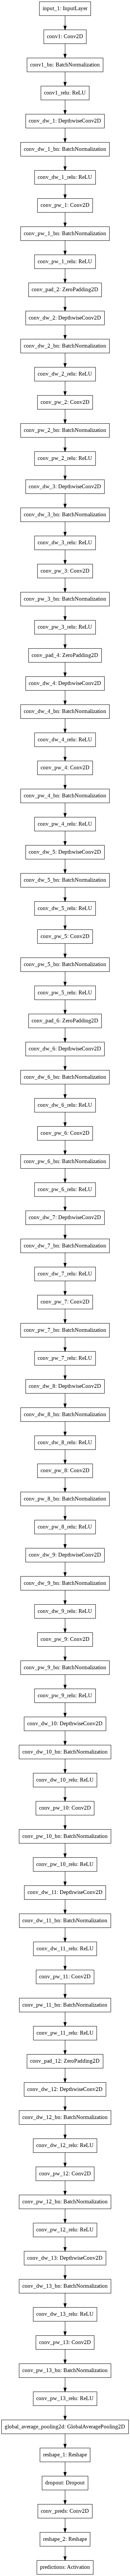

In [ ]:
tf.keras.utils.plot_model(m1,show_layer_names=True)

### Convolution 4가지

```python
1. Convolution
2. Grouped convolution
- 연산량을 줄이기 위해서 convolution연산을 분할 한다 
3. 1x1 convolution 
- 차원을 축소하고 non-linearity 특성을 활용하기 위해 elementwise 연산을 하는 convolution 방법 
4. Depth-wise convolution
- 채널별로 나누어 convolution 연산을 한다 
- 같은 depth끼리 연산한다  
5. Depth-wise seperable convolution
-  Depthwise convolution + 1x1 convolution 
```

## Depth-wise convolution

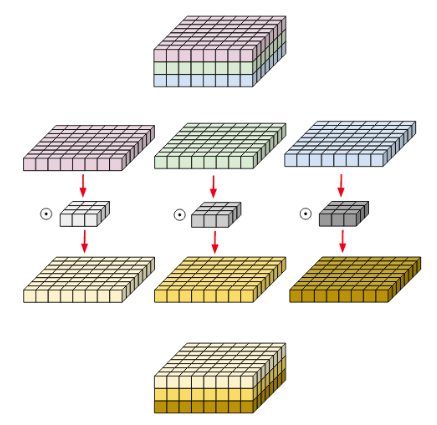

```
Depth wise convolution은 각 채널별로 연산하는 방식으로 
Standard convolution이 각 채널만의 spatial feature를 추출하는것이 불가능하기 때문에 고안해낸 방법이다 

각 채널별로 연산하기 때문에 한번에 연산하는 파라미터의 수를 줄일 수 있는 장점이 있다 
depth wise convolution은 일반 convolution보다 성능은 안좋지만 경량화에 목적이 있기 때문에 성능을 어느정도 감수해야 한다 
가능하다면 성능을 유지하면서 경량화 하는 것을 최대 목표로 삼아야 한다 
하지만 depth를 맞춰야 한다는 단점이 있다 
```

## Depth-wise seperable convolution

```
Depthwise convolution + 1x1 convolution 
```

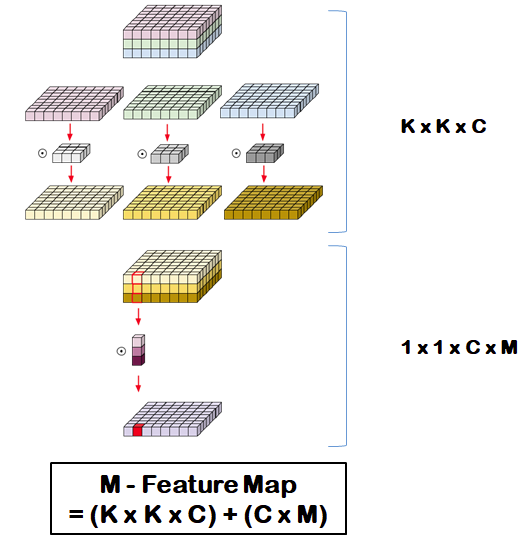

In [ ]:
m2 = tf.keras.applications.MobileNetV2() # ResNet 방식을 따른다 

14548992/14536120 [==============================] - 0s 0us/step


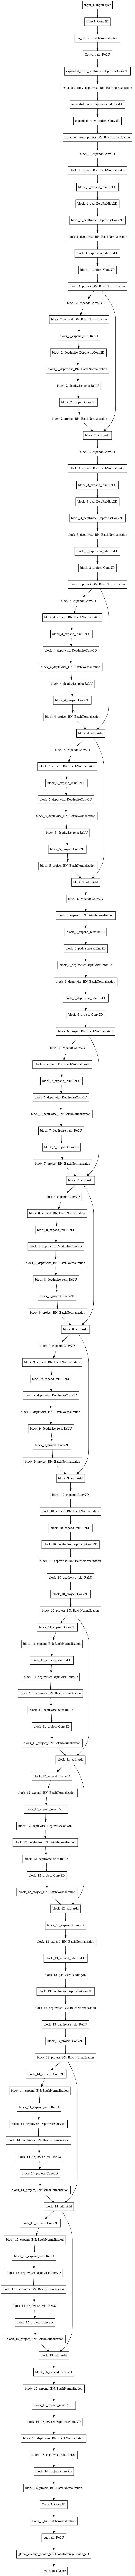

In [ ]:
tf.keras.utils.plot_model(m2 ,show_layer_names=True)

In [ ]:
x = tf.keras.layers.BatchNormalization()
x.build((None,2))
x(tf.constant([[1. ,2.]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.99950033, 1.9990007 ]], dtype=float32)>

In [ ]:
x.weights # gamma, beta는 학습을 통해서 값을 찾는다 

[<tf.Variable 'gamma:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 <tf.Variable 'beta:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'moving_mean:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'moving_variance:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>]

In [ ]:
x.trainable_weights

[<tf.Variable 'gamma:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 <tf.Variable 'beta:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [ ]:
x.non_trainable_weights # 단순 계산 

[<tf.Variable 'moving_mean:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'moving_variance:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>]

In [ ]:
input_ = tf.keras.Input((28,28,1))
x = tf.keras.layers.MaxPool2D(2,2)(input_)
model = tf.keras.models.Model(input_,x)

In [ ]:
model.summary() # pooling은 연산만 하기 때문에 파라미터가 없다 / 학습과 관련이 없다 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 1)         0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160,160,3)) # 배치 크기만큼 입력을 받는다 
x = data_augmentation(inputs) # augmentation 사용 
x = preprocess_input(x)  # 전처리 
x = base_model(x, training=False) # training = False이기 때문에 내부적으로 평균과 표준편차를 구해서 배치마다 다른 평균과 표준편차를 사용할 수 있게 된다 
x = global_average_layer(x) 
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)   # prediction_layer만 backpropagation을 하고 이전 layer에서는 단순 계산만 한다 
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
initial_epochs = 10

train_dataset = image_dataset_from_directory('cats_and_dogs_filtered/train',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory('cats_and_dogs_filtered/validation',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 252s 4s/step - loss: 0.3724 - accuracy: 0.8405 - val_loss: 0.1214 - val_accuracy: 0.9730
Epoch 2/10
63/63 [==============================] - 162s 3s/step - loss: 0.1438 - accuracy: 0.9430 - val_loss: 0.0879 - val_accuracy: 0.9520
Epoch 3/10
63/63 [==============================] - 161s 3s/step - loss: 0.1267 - accuracy: 0.9525 - val_loss: 0.0871 - val_accuracy: 0.9580
Epoch 4/10
63/63 [==============================] - 161s 3s/step - loss: 0.0929 - accuracy: 0.9590 - val_loss: 0.0485 - val_accuracy: 0.9770
Epoch 5/10
63/63 [==============================] - 162s 3s/step - loss: 0.0856 - accuracy: 0.9660 - val_loss: 0.3747 - val_accuracy: 0.9060
Epoch 6/10
63/63 [==============================] - 160s 3s/step - loss: 0.0874 - accuracy: 0.9655 - val_loss: 0.0987 - val_accuracy: 0.9780
Epoch 7/10
63/63 [==============================] - 160s 3s/step - loss: 0.0817 - accuracy: 0.9755 - val_loss: 0.0573 - val_accuracy: 0.9760
Epoch 8/10
63

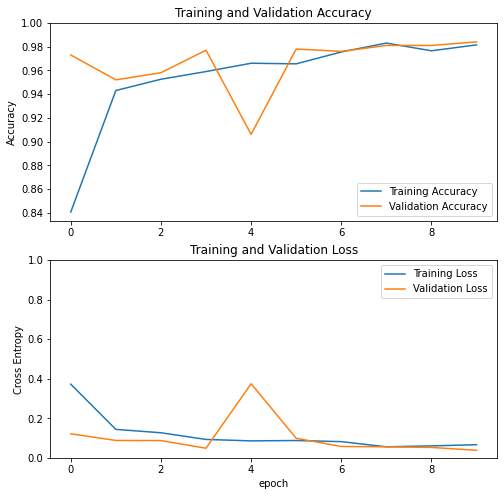

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() 

```
Tensorflow에서는 학습할 때 validation dataset을 포함하면 
평가시 dropout과 batch normalization을 하지 않고 하기 때문에 validation loss가 더 낮게 나오는 경우가 많이 발생한다 
(이런 경우는 underfitting 문제가 아닐 수 있다) 
```

## Fine Tuning 고급 테크닉 

### Fine tuning

```
기존에 학습된 모델을 기반으로 아키텍쳐를 새로운 목적에 맞게 변형하고 이미 학습된 모델 Weights로 부터 학습을 업데이트하는 방법을 말한다.

1. 어느정도 성능이 확보된 모델을 만든다 
2. 일부 Freezon (trainable=False)시키고 느린 learning rate을 통해 나머지를 재학습 시킨다 
3. 새 학습 데이터가 기존 학습 데이터와 큰 차이가 나면 안된다 
4. 새로 학습할 레이어 초기화 하면 기존 능력이 없어지기 때문에 성능이 확보된 모델 가중치를 그대로 사용한다 
```

### 최상위 층 고정 해제하기 

In [ ]:
# Fine tuning이기 때문에 이미 학습된 모델로 사용한다 

base_model.trainable = True # 학습할 수 있도록 우선 만들고 

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]: # 맨 마지막 층을 제외하고 고정시킨다 
  layer.trainable = False                      # 맨 마지막 층은 결과를 내는 층 (개, 고양이 분류)

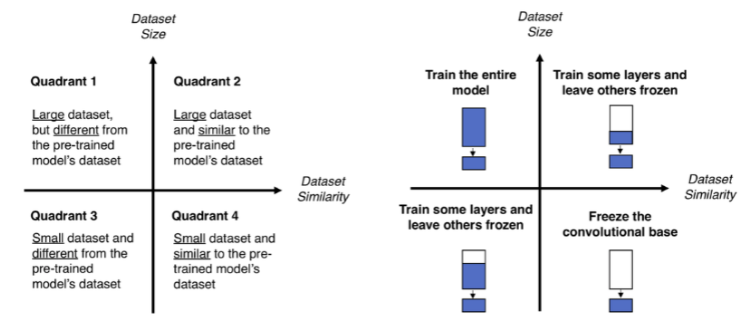

```
Fine tuning 하는 간단한 방식 
1. 가능한 마지막 층 부터 재학습을 한다 (마지막 층들은 전문화된 특징을 분류한다)  
1. learning rate 바꾸기
2. epoch 수 줄이기
```

```
Catastrophic forgetting 
- 다른 종류의 데이터를 학습하면 이전에 학습했던 데이터에 대한 성능이 현저하게 떨어지는 문제
- 이 현상은 이전 학습 dataset과 새로운 학습 dataset 사이에 연관성이 있더라도 이전 dataset에 대한 정보를 대량으로 손실하는 문제가 발생한다 

Semantic shift
- 기존에 학습된 모델에 새로운 형태의 데이터가 추가 학습 되었을 때 가중치가 변하면서 
의미가 변해버리는 현상 
```

## Incremental learning

> 전혀 다른 특징을 가진 데이터 셋을 학습하여 내가 가진 모델에서 전혀 다른 특징을 가진 데이터를 분류할 수 있는 모델로 능력을 키우는 것  

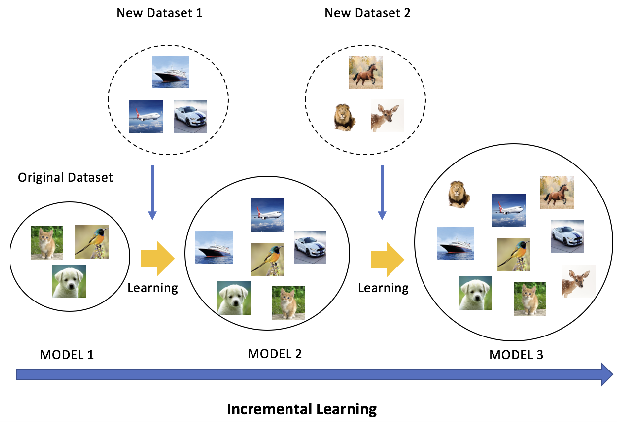